# Imports & Config

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install gsutil mne

     |████████████████████████████████| 2.9MB 8.0MB/s 
     |████████████████████████████████| 6.9MB 51.3MB/s 
     |████████████████████████████████| 174kB 53.6MB/s 
     |████████████████████████████████| 102kB 14.6MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 1.4MB 50.5MB/s 
     |████████████████████████████████| 112kB 54.8MB/s 
     |████████████████████████████████| 3.2MB 46.6MB/s 
  Created wheel for gsutil: filename=gsutil-4.61-cp37-none-any.whl size=3709861 sha256=402986103e82b2d6ce9e9803ea5f183723524f6b9f44c29a489cb90ae69ab490
  Stored in directory: /root/.cache/pip/wheels/21/c8/4c/b30f998197ac91cb58cbc8b63ff3654724f080391131fde96c
  Created wheel for gcs-oauth2-boto-plugin: filename=gcs_oauth2_boto_plugin-2.7-cp37-none-any.whl size=23204 sha256=3770f615de784a1f2460f789fc1db891e1eb04cf46de90841ea2c57e7c875182
  Stored in directory: /root/.cache/pip/wheels/2e/6b/7c/bd86

In [ ]:
!gsutil -m cp -r gs://eegmmidb-1.0.0.physionet.org ./

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import os
import zipfile
import mne
import cv2
import imutils
import tensorflow as tf

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from matplotlib.ticker import ScalarFormatter,AutoMinorLocator

from tensorflow.keras.layers import (
  Input, Dense, Multiply, Activation, Lambda, Reshape, BatchNormalization,
  LeakyReLU, Flatten, Dropout, Concatenate, Add,
  Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D,
)
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import Sequence, plot_model

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from google.colab.patches import cv2_imshow
from itertools import combinations

In [ ]:
np.random.seed(0)

In [ ]:
plt.style.use('/content/fig.mplstyle')

In [ ]:
runs = [i for i in range(2, 15)]
eegbci.load_data(1, runs)

In [ ]:
%mv eegmmidb-1.0.0.physionet.org ../../root/mne_data/MNE-eegbci-data/files/eegmmidb/

In [ ]:
%rm -rf ../../root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/

In [ ]:
%mv ../../root/mne_data/MNE-eegbci-data/files/eegmmidb/eegmmidb-1.0.0.physionet.org ../../root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0

In [ ]:
NFFT = 160
NOVERLAP = NFFT - 1
FS = 160
CMAP = "viridis"
FIGSIZE = (0.54, 0.36)
BATCH_SIZE = 16

# Dataset Loading

In [ ]:
def get_spectrogram(data, fs, nfft, noverlap, figsize, cmap):
  fig, ax = plt.subplots(1, figsize=figsize)
  fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
  fig.dpi = 100
  ax.axis('off')
  ax.grid(False)

  pxx, freqs, bins, im = ax.specgram(x=data, Fs=fs, noverlap=noverlap, NFFT=nfft, cmap=cmap)
  return fig2rgb(fig)

def fig2rgb(fig):
  fig.canvas.draw()
  buf = fig.canvas.tostring_rgb()
  width, height = fig.canvas.get_width_height()
  plt.close(fig)
  return np.frombuffer(buf, dtype=np.uint8).reshape(height, width, 3)

def rgb2gray(rgb_img):
  cv_rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
  cv_gray = cv2.cvtColor(cv_rgb_img, cv2.COLOR_BGR2GRAY)
  return cv_gray

def min_max_scale(spectrogram, f_min, f_max):
  spec_std = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
  spec_scaled = spec_std * (f_max - f_min) + f_min
  return spec_scaled

In [ ]:
def build_dataset(start = 1, end = 20, channel_index = 0):
  dataset = {}

  tmin, tmax = -1., 17.
  event_id = dict(hands=2, feet=3)
  runs = [6, 10, 14]
  subjects = [i for i in range(start, end+1)]
  Y = []
  X = []
  if end > 87 :
    subjects.remove(88)
    subjects.remove(92)
    subjects.remove(100)
  count = 0

  for subject in subjects:
    raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    eegbci.standardize(raw)
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage)

    # strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2
    x = np.array((epochs.get_data(picks='eeg')[:, channel_index, :]), dtype=np.float)
    
    for k in range(x.shape[0]):
      spec = get_spectrogram(x[k,:], FS, NFFT, NOVERLAP, FIGSIZE, CMAP)
      gray_spec = rgb2gray(spec)
      scaled_spec = min_max_scale(gray_spec, 0.0, 1.0)

      if scaled_spec.shape != (36, 54):
        scaled_spec = cv2.resize(scaled_spec, (36, 54))

      reshaped_spec = np.reshape(scaled_spec, (scaled_spec.shape[0], scaled_spec.shape[1], 1))
      X.append(reshaped_spec)
      Y.append(count)
    count += 1

  dataset['x'] = np.array(X)
  dataset['y'] = np.array(Y)
  return dataset

In [ ]:
dataset_train = build_dataset(start=1,end=81, channel_index=63)

In [ ]:
dataset_test = build_dataset(start=82, end=109, channel_index=63)

In [ ]:
print(dataset_train["x"].shape, dataset_train["x"].dtype, dataset_train["y"].shape, dataset_train["y"].dtype)
print(dataset_train["x"].max(), dataset_train["x"].min(), dataset_train["x"].mean(), dataset_train["x"].std())

(3159, 36, 54, 1) float64 (3159,) int64
1.0 0.0 0.4362473307708554 0.3353457333241286


In [ ]:
print(dataset_test["x"].shape, dataset_test["x"].dtype, dataset_test["y"].shape, dataset_test["y"].dtype)
print(dataset_test["x"].max(), dataset_test["x"].min(), dataset_test["x"].mean(), dataset_test["x"].std())

(975, 36, 54, 1) float64 (975,) int64
1.0 0.0 0.43087830260654564 0.3378410312375981


In [ ]:
def split_data_train(dataset, val_split = 0.2):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  
  x = dataset["x"]
  y = dataset["y"]
  no_of_classes = len(np.unique(y))
  for i in range(no_of_classes):
    subject_idx = np.where(y == i)
    idx = subject_idx[0]

    val_count = int(val_split*len(idx))
    
    val_idx = np.random.choice(idx, size=val_count, replace=False)
    for k in val_idx:
      idx = np.delete(idx, np.argwhere(idx == k))
    
    
    for j in val_idx:
      x_val.append(x[j])
      y_val.append(y[j])
    
    
    for j in idx:
      x_train.append(x[j])
      y_train.append(y[j])
        
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_val, y_val = np.array(x_val), np.array(y_val)
  
  x_train, y_train = shuffle(x_train, y_train)
  x_val, y_val = shuffle(x_val, y_val)
  
  return (x_train, y_train, x_val, y_val)

Use channel 22, 55 and 63

In [ ]:
x_train, y_train, x_val, y_val = split_data_train(dataset_train, 0.35)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(2106, 36, 54, 1) (2106,) (1053, 36, 54, 1) (1053,)


In [ ]:
x_test, y_test = shuffle(dataset_test["x"], dataset_test["y"])
print(x_test.shape, y_test.shape)

(975, 36, 54, 1) (975,)


## Make Pairs

In [ ]:
def make_pairs(data, labels):
  pair_signals = []
  pair_subjects = []

  no_of_classes = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, no_of_classes)]

  for person in idx:
    positive_combinations = combinations(person, 2)
    for pair in positive_combinations:
      signal_1_idx = pair[0]
      signal_2_idx = pair[1] 
      current_signal = data[signal_1_idx]
      subject = labels[signal_1_idx]
      pos_signal = data[signal_2_idx]
      pair_signals.append([current_signal, pos_signal])
      pair_subjects.append(0.0)
      
      neg_idx = np.where(labels != subject)[0]
      neg_signal = data[np.random.choice(neg_idx)]
      pair_signals.append([current_signal, neg_signal])
      pair_subjects.append(1.0)

  return (np.array(pair_signals), np.array(pair_subjects))

In [ ]:
(pair_train, label_train) = make_pairs(x_train, y_train)
(pair_val, label_val) = make_pairs(x_val, y_val)
(pair_test, label_test) = make_pairs(x_test, y_test)

In [ ]:
print("Training data: ", pair_train.shape, label_train.shape)
print("Validation data: ", pair_val.shape, label_val.shape)
print("Testing data: ", pair_test.shape, label_test.shape)

Training data:  (52650, 2, 36, 54, 1) (52650,)
Validation data:  (12636, 2, 36, 54, 1) (12636,)
Testing data:  (37050, 2, 36, 54, 1) (37050,)


# Distances

In [ ]:
def euclidean_distance(vects):
  (p , q) = vects
  sum = K.square(p - q)
  return K.sqrt(K.maximum(sum, K.epsilon()))
 
def manhattan_distance(vects):
  (p, q) = vects
  return K.abs(p - q)

SQRT2 = K.sqrt(K.constant(2.0))

def hellinger_distance(vects):
  (p, q) = vects
  # return K.sqrt(K.sum(K.square(p - q), axis=1, keepdims=True)) / SQRT2
  # return K.square(p - q) / SQRT2
  return K.sqrt(K.maximum(K.square(K.sqrt(p) - K.sqrt(q)), K.epsilon())) / SQRT2

# Loss & Accuracy

In [ ]:
def contrastive_loss(y_true, y_pred):
  margin = 1.0
  return K.mean((1.0 - y_true) * K.square(y_pred) + (y_true) * K.square(K.maximum(margin - y_pred, 0.0)))

def custom_acc(y_true, y_pred):
  return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

# Model Building

## Sequential

In [ ]:
def build_sequential(cnn_input=None):
  x = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(cnn_input)
  x = BatchNormalization()(x)

  x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

  x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

  x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  x = GlobalAveragePooling2D()(x)

  # x = Dropout(0.2)(x)

  x = Activation("sigmoid")(x)
  return x

In [ ]:
def build_model(height, width, channels, model_type, distance_metric):
  model_types = {
    "sequential": build_sequential,
  }

  distance_metrics = {
    "euclidean": euclidean_distance,
    "manhattan": manhattan_distance,
    "hellinger": hellinger_distance,
  }

  input_shape=(height, width, channels)
  
  # Siamese Input ----------------------------------------------------------------------------
  siamese_left_input = Input(shape=input_shape)
  siamese_right_input = Input(shape=input_shape)
  # ------------------------------------------------------------------------------------------

  # CNN --------------------------------------------------------------------------------------
  cnn_input = Input(shape=input_shape)
  cnn_output = model_types[model_type](cnn_input)
  cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
  # -------------------------------------------------------------------------------------------

  # Siamese Output-----------------------------------------------------------------------------
  encoded_l = cnn_model(siamese_left_input)
  encoded_r = cnn_model(siamese_right_input)

  distance = Lambda(distance_metrics[distance_metric])([encoded_l, encoded_r])

  drop = Dropout(0.4)(distance)

  dense = Dense(64)(drop)

  siamese_output = Dense(1, activation="sigmoid")(dense)
  siamese_net = Model(inputs=[siamese_left_input, siamese_right_input], outputs=siamese_output)
  # -------------------------------------------------------------------------------------------

  return siamese_net, cnn_model

In [ ]:
model, cnn_model = build_model(36, 54, 1, "sequential", "hellinger")
model.summary()Code for Architecture of Convolutional Siamese Network using Keras
cnn_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 36, 54, 1)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 36, 54, 1)]  0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 256)          371456      input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256)          0           model_4[0][0]              

In [ ]:
# plot_model(model, "/content/model.png", show_layer_names=True, show_shapes=True)
# plot_model(cnn_model, "/content/cnn_model.png", show_layer_names=True, show_shapes=True)

# Model Training

In [ ]:
INIT_LR = 0.0005
EPOCHS = 25
BATCH_SIZE = 16

def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0

  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

callbacks = [LearningRateScheduler(poly_decay)]
opt = Adam(lr=INIT_LR, amsgrad=True)

In [ ]:
model.compile(loss=contrastive_loss, optimizer=opt)

In [ ]:
%%time
r = model.fit(
  [pair_train[:, 0], pair_train[:, 1]], label_train[:],
  validation_data = ([pair_val[:, 0], pair_val[:, 1]], label_val[:]),
  batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks,
)

Epoch 1/25
3291/3291 [==============================] - 32s 9ms/step - loss: 0.1061 - val_loss: 0.0863
Epoch 2/25
3291/3291 [==============================] - 30s 9ms/step - loss: 0.0564 - val_loss: 0.0702
Epoch 3/25
3291/3291 [==============================] - 30s 9ms/step - loss: 0.0468 - val_loss: 0.0543
Epoch 4/25
3291/3291 [==============================] - 30s 9ms/step - loss: 0.0448 - val_loss: 0.0454
Epoch 5/25
3291/3291 [==============================] - 31s 9ms/step - loss: 0.0435 - val_loss: 0.0276
Epoch 6/25
3291/3291 [==============================] - 31s 9ms/step - loss: 0.0381 - val_loss: 0.0228
Epoch 7/25
3291/3291 [==============================] - 30s 9ms/step - loss: 0.0331 - val_loss: 0.0296
Epoch 8/25
3291/3291 [==============================] - 30s 9ms/step - loss: 0.0331 - val_loss: 0.0317
Epoch 9/25
3291/3291 [==============================] - 30s 9ms/step - loss: 0.0312 - val_loss: 0.0256
Epoch 10/25
3291/3291 [==============================] - 30s 9ms/step - l

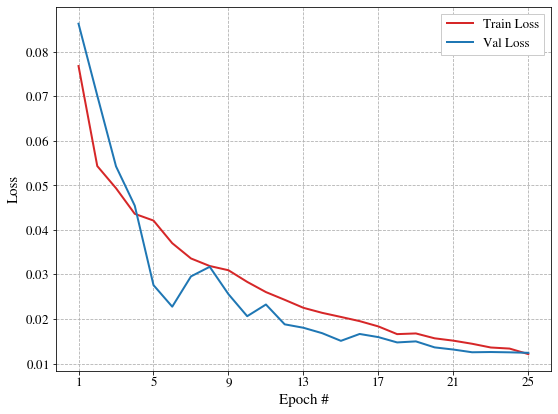

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

plt.xticks(np.arange(1,26, 4))

ax.plot(np.arange(1, EPOCHS+1), r.history["loss"], linestyle = '-', lw=2, label="Train Loss", alpha=1, color="tab:red")
ax.plot(np.arange(1, EPOCHS+1), r.history["val_loss"], linestyle = '-', lw=2, label="Val Loss", alpha=1, color="tab:blue")

ax.set_xlabel('Epoch #')
ax.set_ylabel('Loss')

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.legend(frameon=True, loc='best',ncol=1, handlelength=2, framealpha=1, edgecolor="0.8", fancybox=False)
plt.grid(True, ls="--", lw=0.8)

plt.savefig('/content/training.png', dpi=300, transparent=False, bbox="tight")
plt.show()

# Model Evaluation

In [ ]:
model.evaluate([pair_test[:, 0], pair_test[:, 1]], label_test[:], batch_size=BATCH_SIZE)

2316/2316 [==============================] - 7s 3ms/step - loss: 0.0243


0.02425462193787098

In [ ]:
model.save('/content/siamese_mi_channel_63-loss:{:.3f}.h5'.format(r.history['val_loss'][-1]))

In [ ]:
import json
with open("/content/history-loss:{:.3f}.json".format(r.history['val_loss'][-1]), "w") as f:
  json.dump(str(r.history), f)

# Model Inference

In [ ]:
model = load_model("/content/siamese_mi_channel_63_loss_0.0134.h5", custom_objects={"contrastive_loss": contrastive_loss})

In [ ]:
preds = model.predict([pair_test[:, 0], pair_test[:, 1]])

In [ ]:
avg_sim = []
avg_nsim = []

for i, j in enumerate(preds):
  if i%2 == 0:
    avg_sim.append(j[0])
  else:
    avg_nsim.append(j[0])

threshold = (np.mean(avg_sim) + np.mean(avg_nsim))/2

print("Similar: ", np.mean(avg_sim))
print("Dissimilar: ", np.mean(avg_nsim))
print("Threshold: ", threshold)

Similar:  0.04298184
Dissimilar:  0.9609575
Threshold:  0.5019696950912476


# One Shot Task

In [ ]:
def make_one_shot_task(x, y, n):
  no_of_classes = len(np.unique(y))
  support_set = np.zeros((n,2,36,54,1))
  target_labels = []
  subject_ids = np.arange(0, no_of_classes)

  idx = [np.where(y == i)[0] for i in range(0, no_of_classes)]
  
  query_subject_id = np.random.choice(subject_ids)
  query_subject_idxs = idx[query_subject_id]
  query_subject_idx = np.random.choice(query_subject_idxs)
  query_subject_signal = x[query_subject_idx]

  pos_signal_idx = np.random.choice(query_subject_idxs[np.where(query_subject_idxs != query_subject_idx)])
  pos_signal = x[pos_signal_idx]
  support_set[0,0,:,:,:] = query_subject_signal
  support_set[0,1,:,:,:] = pos_signal

  neg_subject_ids = np.random.choice(subject_ids[np.where(subject_ids != query_subject_id)], n-1, replace=False)
  for j in range(n-1):
    neg_signal_idx = np.random.choice(idx[neg_subject_ids[j]])
    neg_signal = x[neg_signal_idx]
    support_set[j+1,0,:,:,:] = query_subject_signal
    support_set[j+1,1,:,:,:] = neg_signal

  return support_set

def test_one_shot_task(model, k, n, x, y, dataset_type):
  ccr = []
  for i in range(k):
    support_set = make_one_shot_task(x, y, n)
    preds = model.predict([support_set[:,0], support_set[:,1]])
    preds = np.reshape(preds, (preds.shape[0],))

    if preds.min() == preds[0]:
      ccr.append(1.0)

  ccr_score = sum(ccr)/k
  print("{} CCR Score of {} way 1 shot learning for {} trials = {:.3f}".format(dataset_type, n, k, ccr_score))
  return ccr_score

In [ ]:
N_WAY = 25

test_ccrs = [test_one_shot_task(model, 500, f, x_test, y_test, "Test") for f in range(1,N_WAY+1,1)]
# val_ccrs = [test_one_shot_task(model, 100, f, x_val, y_val, "Validation") for f in range(1, N_WAY+1,1)]

Test CCR Score of 1 way 1 shot learning for 500 trials = 1.000
Test CCR Score of 2 way 1 shot learning for 500 trials = 0.996
Test CCR Score of 3 way 1 shot learning for 500 trials = 0.990
Test CCR Score of 4 way 1 shot learning for 500 trials = 0.986
Test CCR Score of 5 way 1 shot learning for 500 trials = 0.984
Test CCR Score of 6 way 1 shot learning for 500 trials = 0.984
Test CCR Score of 7 way 1 shot learning for 500 trials = 0.986
Test CCR Score of 8 way 1 shot learning for 500 trials = 0.982
Test CCR Score of 9 way 1 shot learning for 500 trials = 0.984
Test CCR Score of 10 way 1 shot learning for 500 trials = 0.974
Test CCR Score of 11 way 1 shot learning for 500 trials = 0.974
Test CCR Score of 12 way 1 shot learning for 500 trials = 0.958
Test CCR Score of 13 way 1 shot learning for 500 trials = 0.956
Test CCR Score of 14 way 1 shot learning for 500 trials = 0.952
Test CCR Score of 15 way 1 shot learning for 500 trials = 0.958
Test CCR Score of 16 way 1 shot learning for 500 

In [ ]:
random_ccrs = [1/i for i in range(1, N_WAY+1,1)]

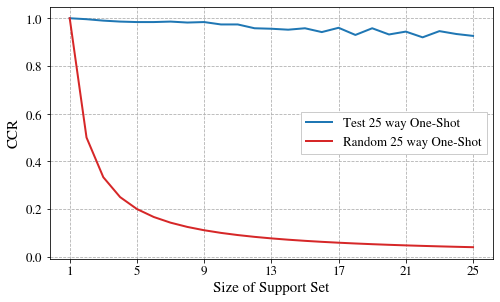

In [ ]:
fig, ax = plt.subplots()

plt.xticks(np.arange(1,N_WAY+1, 4))
# plt.yticks(np.arange(0.9,1,0.01))

ax.plot(np.arange(1, N_WAY+1), test_ccrs, linestyle = '-', lw=2, label="Test {} way One-Shot".format(N_WAY), alpha=1, color="tab:blue")
ax.plot(np.arange(1, N_WAY+1), random_ccrs, linestyle = '-', lw=2, label="Random {} way One-Shot".format(N_WAY), alpha=1, color="tab:red")

ax.set_xlabel('Size of Support Set')
ax.set_ylabel('CCR')

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.legend(frameon=True, loc='best',ncol=1, handlelength=2, framealpha=1, edgecolor="0.8", fancybox=False)
plt.grid(True, ls="--", lw=0.8)

plt.savefig('/content/one_shot.png', dpi=300, transparent=False, bbox="tight")
plt.show()

# Rank N Accuracy

In [ ]:
def rank_n_acc(x, y):
  no_of_classes = len(np.unique(y))
  idx = [np.where(y == i)[0] for i in range(0, no_of_classes)]

  subjects_rank1 = []
  subjects_rank5 = []
  for i in range(no_of_classes):
    success_count_1 = 0
    success_count_5 = 0
    count = 0
  
    for j in range(len(idx[i])):
      query_x = x[idx[i][j]]
      result = []
      for k in range(no_of_classes):
        subject_set = np.zeros((len(idx[k]), 2, 36, 54, 1))
        if k == i:
          subject_set = np.zeros((len(idx[k])-1, 2, 36, 54, 1))
          
        idx_count = 0  
        for l in idx[k]:
          if idx[i][j] != l:
            subject_set[idx_count,0,:,:,:] = x[l]
            subject_set[idx_count,1,:,:,:] = query_x
            idx_count += 1

        subject_result = np.mean(np.squeeze(model.predict([subject_set[:,0], subject_set[:, 1]]), axis = -1))
        result.append((subject_result, k))

      result.sort(key=lambda e: e[0])
      top_5 = [ result[a][1] for a in range(5)]
      if i in top_5:
        success_count_5 += 1

      top_1 = [ result[a][1] for a in range(1)]
      if i in top_1:
        success_count_1 += 1

      count += 1
    subjects_rank1.append(success_count_1/count)
    subjects_rank5.append(success_count_5/count)
    print("Rank_1: {:.4f} - Rank_5: {:.4f}".format(success_count_1/count, success_count_5/count))
  return subjects_rank1, subjects_rank5

In [ ]:
subjects_rank1, subjects_rank5 = rank_n_acc(x_test, y_test)

In [ ]:
for i,(j,k) in enumerate(zip(subjects_rank1, subjects_rank5)):
  print("Subject_id: {} - Rank_1: {:.4f} - Rank_5: {:.4f}".format(i,j,k))

Subject_id: 0 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 1 - Rank_1: 0.9487 - Rank_5: 1.0000
Subject_id: 2 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 3 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 4 - Rank_1: 0.9744 - Rank_5: 1.0000
Subject_id: 5 - Rank_1: 0.8974 - Rank_5: 1.0000
Subject_id: 6 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 7 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 8 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 9 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 10 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 11 - Rank_1: 0.7436 - Rank_5: 1.0000
Subject_id: 12 - Rank_1: 0.8205 - Rank_5: 1.0000
Subject_id: 13 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 14 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 15 - Rank_1: 0.9487 - Rank_5: 1.0000
Subject_id: 16 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 17 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 18 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 19 - Rank_1: 1.0000 - Rank_5: 1.0000
Subject_id: 20 - Rank_1: 1.000

In [ ]:
print(np.mean(subjects_rank1), np.std(subjects_rank1))

0.9723076923076923 0.061930375956720116


# FAR, FRR, HTER, EER, ROC

In [ ]:
preds = 1.0 - np.squeeze(model.predict([pair_test[:, 0], pair_test[:, 1]]), axis=-1)
far = []
frr = []
thresholds = np.arange(0,1.01, 0.01)
for threshold in thresholds:
  positive_count = 0
  negative_count = 0
  false_positive_count = 0
  false_negative_count = 0
  for i in range(len(label_test)):
    # Actual Similar
    if label_test[i] == 0:
      positive_count += 1

      # Predicting Dissimilar
      if preds[i]<threshold:
        false_negative_count += 1
    # Actual Dissimilar
    else:
      negative_count += 1
      # Predicting Similar
      if preds[i]>=threshold:
        false_positive_count += 1
    
  far.append(false_positive_count/negative_count)
  frr.append(false_negative_count/positive_count)

far = np.array(far)
frr = np.array(frr)
hter = (far+frr)/2.0

diff = np.absolute(far-frr)

eer_idx = np.argmin(diff)
print("EER: ", (far[eer_idx] + frr[eer_idx])/2.0)

EER:  0.031497975708502025


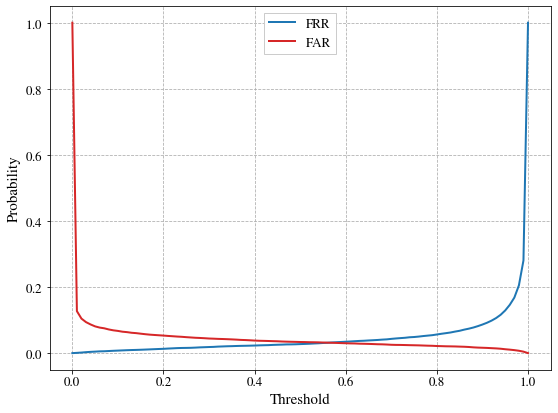

In [ ]:
fig, ax = plt.subplots()

# plt.xticks(np.arange(1,N_WAY+1, 15))
# plt.yticks(np.arange(0.9,1,0.01))

ax.plot(thresholds, frr, linestyle = '-', lw=2, alpha=1, label="FRR", color="tab:blue")
ax.plot(thresholds, far, linestyle = '-', lw=2, alpha=1, label="FAR", color="tab:red")

ax.set_xlabel('Threshold')
ax.set_ylabel('Probability')

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.legend(frameon=True, loc='best',ncol=1, handlelength=2, framealpha=1, edgecolor="0.8", fancybox=False)
plt.grid(True, ls="--", lw=0.8)

plt.savefig('/content/far_frr.png', dpi=300, transparent=False, bbox="tight")
plt.show()

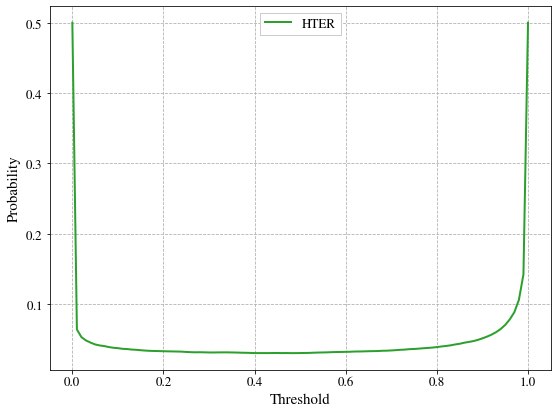

In [ ]:
fig, ax = plt.subplots()

# plt.xticks(np.arange(1,N_WAY+1, 15))

ax.plot(thresholds, hter, linestyle = '-', lw=2, alpha=1, label="HTER", color="tab:green")

ax.set_xlabel('Threshold')
ax.set_ylabel('Probability')

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.legend(frameon=True, loc='best',ncol=1, handlelength=2, framealpha=1, edgecolor="0.8", fancybox=False)
plt.grid(True, ls="--", lw=0.8)

plt.savefig('/content/hter.png', dpi=300, transparent=False, bbox="tight")
plt.show()

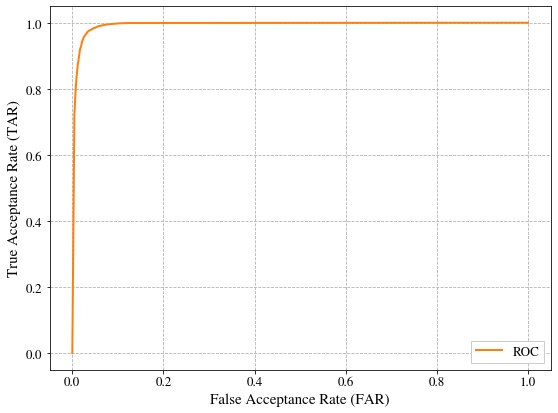

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

# plt.xticks(np.arange(1,N_WAY+1, 15))

ax.plot(far, 1-np.array(frr), linestyle = '-', lw=2, alpha=1,label="ROC", color="tab:orange")
# ax.plot(far, frr, linestyle = '-', lw=2, alpha=1,label="DET", color="tab:red")

ax.set_xlabel('False Acceptance Rate (FAR)')
ax.set_ylabel('True Acceptance Rate (TAR)')

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.legend(frameon=True, loc='best',ncol=1, handlelength=2, framealpha=1, edgecolor="0.8", fancybox=False)
plt.grid(True, ls="--", lw=0.8)

plt.savefig('/content/roc.png', dpi=300, transparent=False, bbox="tight")
plt.show()

In [ ]:
preds = np.round(np.squeeze(model.predict([pair_test[:, 0], pair_test[:, 1]]), axis=-1))

target_names = ['Similar', 'Dissimilar']
print(classification_report(label_test, preds, target_names=target_names))

              precision    recall  f1-score   support

     Similar       0.97      0.97      0.97     18525
  Dissimilar       0.97      0.97      0.97     18525

    accuracy                           0.97     37050
   macro avg       0.97      0.97      0.97     37050
weighted avg       0.97      0.97      0.97     37050



In [ ]:
def plot_confusion_matrix_custom(cm, classes, normalize=False, cmap='PuBuGn'):
  # plt.figure(figsize=[8,8])
  import itertools
  plt.grid(b=None)
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('Ground Truth Label')
  plt.xlabel('Predicted Label')
  plt.tight_layout()
  plt.grid(False)
  plt.savefig('/content/cm.png', dpi=300, transparent=False, bbox="tight")
  plt.show()

Confusion matrix, without normalization
[[18019   506]
 [  624 17901]]


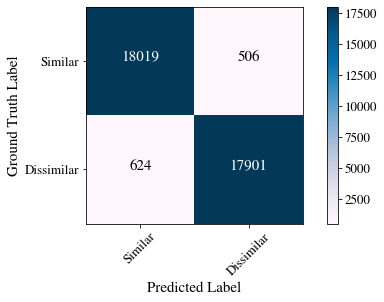

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

confusion_matrix_output = confusion_matrix(label_test, preds)
plot_confusion_matrix_custom(confusion_matrix_output, classes=target_names, cmap="PuBu")